In [1]:
import os
import math

import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, config_enumerate
from pyro.contrib.tracking.extended_kalman_filter import EKFState
from pyro.contrib.tracking.distributions import EKFDistribution
from pyro.contrib.tracking.dynamic_models import NcvContinuous, DifferentiableDynamicModel
from pyro.contrib.tracking.measurements import PositionMeasurement

from pyro.infer.mcmc import MCMC, NUTS, HMC

smoke_test = ('CI' in os.environ)
#assert pyro.__version__.startswith('0.3.0')
pyro.enable_validation(True)

import matplotlib.pyplot as plt

In [2]:
dt = 1e-0
num_frames = 200
dim = 2

def truth(t):
    if t < 40:
        return 10 * t, 10
    else:
        return 10 * t + 0.5 * (t - 40) ** 2, 10 + (t - 40)

# Continuous model
ncv = NcvContinuous(dim, 1.0)

# Truth trajectory

#xs_truth = torch.zeros(num_frames, dim)
xs_truth = torch.Tensor([truth(i * dt) for i in range(num_frames)])
# initial direction
#theta0_truth = 0.0
# initial state
#with torch.no_grad():
#    #xs_truth[0, :] = torch.tensor([0.0, 0.0,  math.cos(theta0_truth), math.sin(theta0_truth)])
#    xs_truth[0, :] = torch.tensor([0.0])
#    for frame_num in range(1, num_frames):
#        # sample independent process noise
#        dx = pyro.sample('process_noise_{}'.format(frame_num), ncv.process_noise_dist(dt))
#        xs_truth[frame_num, :] = ncv(xs_truth[frame_num-1, :], dt=dt) + dx

In [3]:
class MyDynamicModel(DifferentiableDynamicModel):
    def __init__(self, sd=0):
        super(MyDynamicModel, self).__init__(2, 2, num_process_noise_parameters=None)
        self.var = sd * sd
    
    def forward(self, x, dt, do_normalization=True):
        return torch.Tensor([x[0] + x[1] * dt, x[1]])
    
    def mean2pv(self, x):
        return x
    
    def cov2pv(self, x):
        return x
    
    def process_noise_cov(self, dt):
        return torch.diag(torch.Tensor([0, self.var * dt]))
    
    def jacobian(self, dt):
        return torch.Tensor([[1, dt],
                             [0, 1]])

In [4]:
#ncv = MyDynamicModel()

In [5]:
# Measurements
#mean = torch.zeros(2)
## no correlations
#cov = 1e-5 * torch.eye(2)
#with torch.no_grad():
#    # sample independent measurement noise
#    dzs = pyro.sample('dzs', dist.MultivariateNormal(mean, cov).expand((num_frames,)))
#    # compute measurement means
#    zs = xs_truth[:, :2] + dzs
zs = xs_truth[:, :1]
zs = zs + 200 * torch.randn_like(zs)

In [6]:
def model(data):
    # a HalfNormal can be used here as well
    R = pyro.sample('pv_cov', dist.HalfCauchy(200)) * torch.eye(2)
    Q = pyro.sample('measurement_cov', dist.HalfCauchy(20000)) * torch.eye(1)
    # observe the measurements
    ekf = EKFDistribution(xs_truth[0], R, ncv, Q, time_steps=num_frames)
    #print(ekf.event_shape)
    pyro.sample('track', ekf, obs=data)

guide = AutoDelta(model)  # MAP estimation

In [7]:
nuts_kernel = NUTS(model, step_size=0.01)
mcmc_run = MCMC(nuts_kernel, num_samples=200, warmup_steps=200).run(zs)
#hmc_kernel = HMC(model, step_size=0.01, num_steps=2)
#mcmc_run = MCMC(hmc_kernel, num_samples=1000, warmup_steps=600).run(zs)


Warmup:  10%|█         | 42/400 [10:29<1:19:56, 13.40s/it, step size=3.51e-02, acc. rate=0.833]


KeyboardInterrupt: 

In [ ]:
spls_pv   = pyro.infer.EmpiricalMarginal(mcmc_run, 'pv_cov')._samples
spls_meas = pyro.infer.EmpiricalMarginal(mcmc_run, 'measurement_cov')._samples

In [ ]:
plt.figure(figsize=(14, 12))
plt.scatter(spls_pv.numpy(), spls_meas.numpy())

In [8]:
optim = pyro.optim.Adam({'lr': 0.4})
svi = SVI(model, guide, optim, loss=Trace_ELBO(retain_graph=True))

pyro.set_rng_seed(0)
pyro.clear_param_store()

for i in range(100):
    loss = svi.step(zs)
    if not i % 10:
        print('loss: ', loss)

loss:  1549.5081386566162
loss:  1467.6962146759033
loss:  1454.3654356002808
loss:  1450.28470993042
loss:  1449.0763030052185
loss:  1448.8916940689087
loss:  1448.8231167793274
loss:  1448.7999091148376
loss:  1448.7830719947815
loss:  1448.771141052246


In [9]:
dict(pyro.get_param_store())

{'auto_pv_cov': tensor(0.2924, grad_fn=<AddBackward0>),
 'auto_measurement_cov': tensor(47221.9102, grad_fn=<AddBackward0>)}

In [10]:
R = pyro.param('auto_pv_cov') * torch.eye(2)
Q = pyro.param('auto_measurement_cov') * torch.eye(1)
ekf_dist = EKFDistribution(xs_truth[0], R, ncv, Q, time_steps=num_frames)
states = ekf_dist.filter_states(zs)


In [11]:
res = np.array([state.mean.detach().cpu().numpy() for state in states])

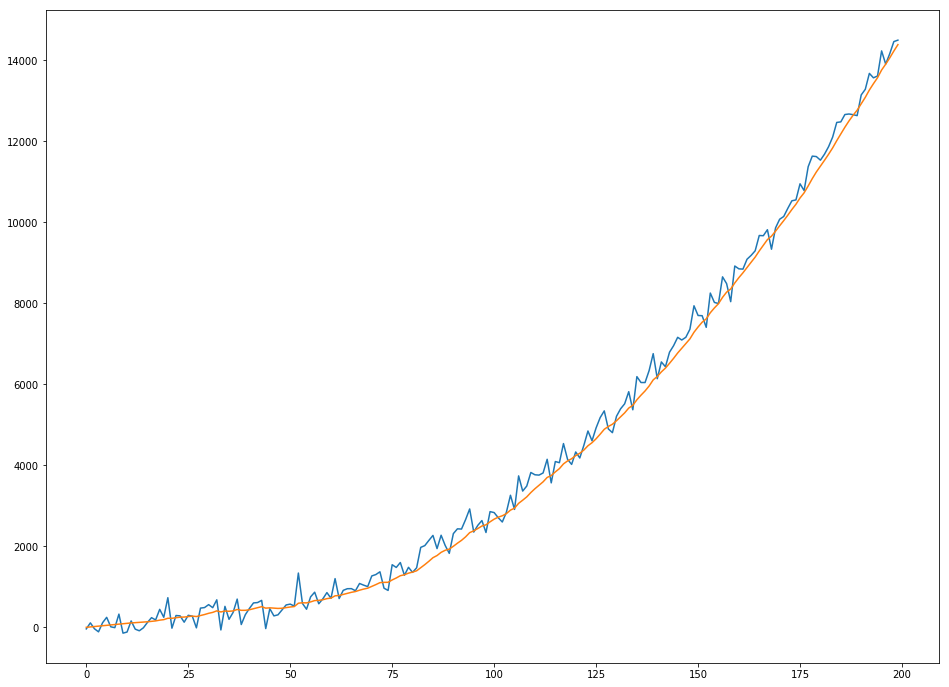

In [13]:
plt.figure(figsize=(16, 12))
plt.plot(zs[:,0].numpy())
#plt.plot(xs_truth[:,0].numpy())
plt.plot(res[:,0])
